# 移动平均线
*用Python量化你的技术分析*

## 目录
- 均线是什么？
- 不同均线是怎么计算的？
- 均线如何用图表显示？
- 如何用均线构建策略？

## 均线是什么？
均线理论是当今应用最普遍的技术指标之一，它帮助交易者确认现有趋势、判断将出现的趋势、发现过度延生即将反转的趋势。另外均线与趋势是西蒙斯被TED采访时提到的关键词，因此做量化你必须懂，而且是深入地懂这两个词的真正意义。

## 不同均线是怎么计算的？
---

### 1. Simple Moving Average 平滑价格

## $MA_n=\frac{X_1+X_2+...X_n}{n}$

---

### 2. Weighted Moving Average 用权重方法突出前段

## $W_t=\frac{w_1P_{t-n+1}+w_2P_{t-n+2}+...+w_{n-1}P_{t-1}+w_nP_t}{w_1+w_2+...+w_n}$

## $w_1<w_2<...<w_n$

---

### 3. Triangular Moving Average 突出中间,用于周期分析

## $TMA_5=\frac{P_1+2P_2+3P_3+2P_4+P_5}{9}$

---

### 4. Exponential Moving Average 用指数方法突出前段

## $EMA_t=\frac{a^nP_{t-n+1}+a^{n-1}P_{t-n+2}+...+a^2P_{t-1}+aP_t}{a^n+a^{n-1}+...+a^2+a}$

## $EMA_t=α*Price_t + ( 1 - α ) * EMA_{t-1}$

## $α为平滑指数，一般取作2/(n+1)$

---

### 5. Double Exponential Moving Average 突出EMA,减少滞后。

## $DEMA = 2*EMA-EMA(EMA)$

---

### 6. Kaufman Adaptive Moving Average 自适应自适应市场变化与波动

## $ER = Change/Volatility$

## $Change = ABS(Close - Close (10 periods ago))$

## $Volatility = Sum_{10}(ABS(Close_t - Close_{t-1}))$

## $\text{Volatility is the sum of the absolute value of the last ten price changes (Close - Prior Close)}$

## $SC = [ER * (fastest SC - slowest SC) + slowest SC]^2$

## $SC = [ER * (2/(2+1) - 2/(30+1)) + 2/(30+1)]^2$

## $Current KAMA = Prior KAMA + SC * (Price - KAMA_{t-1})$



## 均线如何用图表显示？


In [4]:
from jaqs.data import DataView
from jaqs.data import RemoteDataService
import os
import numpy as np
import talib as ta
from talib import abstract
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")
dv = DataView()
dataview_folder = '../Factor'
dv.load_dataview(dataview_folder)

Dataview loaded successfully.


In [5]:
def change_index(df):
    df.index = pd.Index(map(lambda x: datetime.strptime(str(x),"%Y%m%d") , df.index))
    return df

In [6]:
data = change_index(dv.get_ts('close').loc[20170105:])

data['SMA'] = abstract.MA(data, 20, price='600036.SH')
data['WMA'] = abstract.WMA(data, 20, price='600036.SH')
data['TRIMA'] = abstract.TRIMA(data, 20, price='600036.SH')
data['EMA']  = abstract.EMA(data, 20, price='600036.SH')
data['DEMA'] = abstract.DEMA(data, 20, price='600036.SH')
data['KAMA'] = abstract.KAMA(data, 20, price='600036.SH')

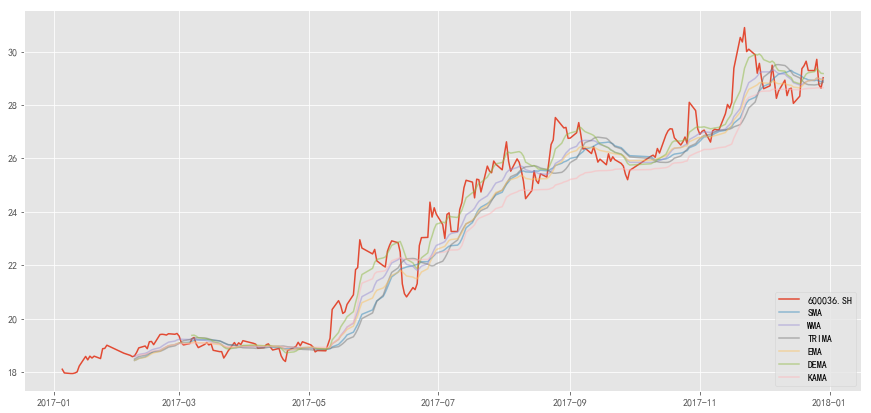

In [13]:
fig = plt.figure(figsize=(15, 7))
plt.plot(data['600036.SH'])
plt.plot(data['SMA'], alpha=0.5)
plt.plot(data['WMA'], alpha=0.5)
plt.plot(data['TRIMA'], alpha=0.5)
plt.plot(data['EMA'], alpha=0.5)
plt.plot(data['DEMA'], alpha=0.5)
plt.plot(data['KAMA'], alpha=0.5)
plt.legend(loc='lower right')
plt.show()

## 如何用均线构建策略？
**两条均线的三种交易方法**
1. 当均线金叉（短期大于长期均线）时候买进，死叉（短期小于长期）时卖出。 
2. 当价格上穿两条均线时买入，但价格下穿其中一条均线时卖出。 
3. 当两条均线都处于向上方向时买入，当两条均线都处于下跌方向时卖出。

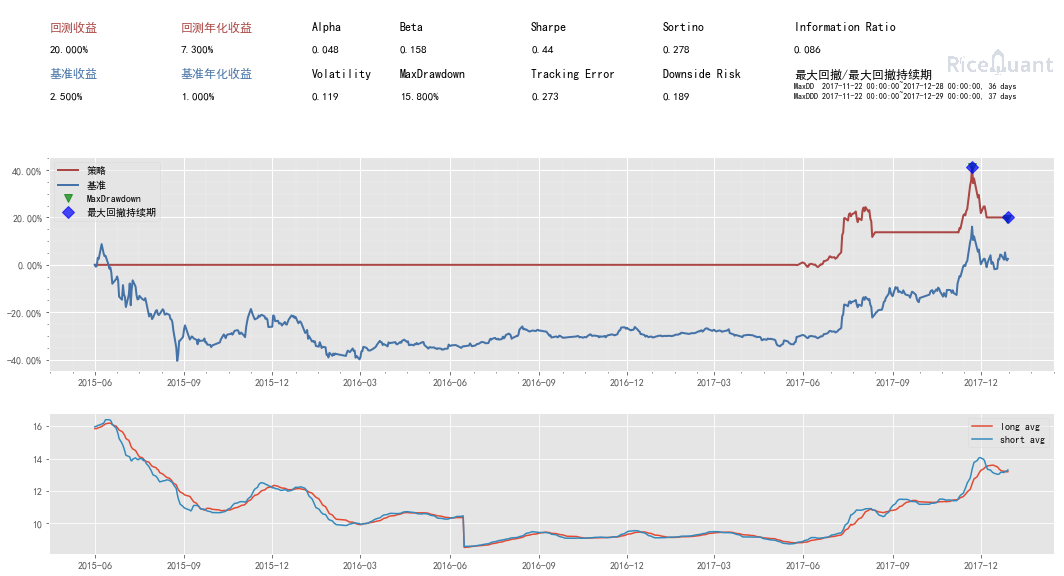

{'sys_analyser': {'summary': {'strategy_name': 'strategy',
   'start_date': '2015-06-01',
   'end_date': '2017-12-29',
   'strategy_file': 'strategy.py',
   'run_type': 'BACKTEST',
   'benchmark': '000001.XSHE',
   'STOCK': 1000000.0,
   'alpha': 0.048,
   'beta': 0.158,
   'sharpe': 0.44,
   'information_ratio': 0.086,
   'downside_risk': 0.189,
   'tracking_error': 0.273,
   'sortino': 0.278,
   'volatility': 0.119,
   'max_drawdown': 0.158,
   'total_value': 1199964.996,
   'cash': 304.996,
   'total_returns': 0.2,
   'annualized_returns': 0.073,
   'unit_net_value': 1.2,
   'units': 1000000.0,
   'benchmark_total_returns': 0.025,
   'benchmark_annualized_returns': 0.01},
  'trades':                      commission         exec_id  last_price  last_quantity  \
  datetime                                                                     
  2017-05-25 15:00:00    799.3440  15336997800000        9.10         109800   
  2017-08-14 15:00:00    897.7248  15336997800001       10.22     

In [8]:
#MA_Strategy_1

import rqalpha
from rqalpha.api import *
import talib

def init(context):
    context.s1 = "000001.XSHE"
    context.SHORTPERIOD = 10
    context.LONGPERIOD = 20


def handle_bar(context, bar_dict):

    price = history_bars(context.s1, context.LONGPERIOD+1, '1d', 'close')

    short_avg = talib.SMA(price, context.SHORTPERIOD)
    long_avg = talib.SMA(price, context.LONGPERIOD)

    plot("short avg", short_avg[-1])
    plot("long avg", long_avg[-1])

    # 计算现在portfolio中股票的仓位
    cur_position = context.portfolio.positions[context.s1].quantity
    # 计算现在portfolio中的现金可以购买多少股票
    shares = context.portfolio.cash/bar_dict[context.s1].close

    # 如果短均线从上往下跌破长均线，也就是在目前的bar短线平均值低于长线平均值，而上一个bar的短线平均值高于长线平均值
    if short_avg[-1] - long_avg[-1] < 0 and short_avg[-2] - long_avg[-2] > 0 and cur_position > 0:
        # 进行清仓
        order_target_value(context.s1, 0)

    # 如果短均线从下往上突破长均线，为入场信号
    if short_avg[-1] - long_avg[-1] > 0 and short_avg[-2] - long_avg[-2] < 0:
        # 满仓入股
        order_shares(context.s1, shares)

config = {
  "base": {
    "start_date": "2015-06-01",
    "end_date": "2017-12-31",
    "accounts": {'stock':1000000},
    "benchmark": "000001.XSHE"
  },
  "extra": {
    "log_level": "error",
  },
  "mod": {
    "sys_analyser": {
      "enabled": True,
      "plot": True
    }
  }
}

rqalpha.run_func(init=init, handle_bar=handle_bar, config=config)

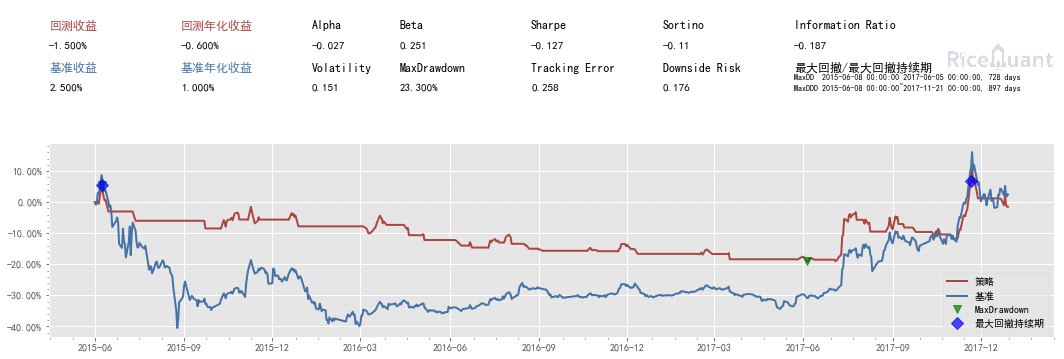

{'sys_analyser': {'summary': {'strategy_name': 'strategy',
   'start_date': '2015-06-01',
   'end_date': '2017-12-29',
   'strategy_file': 'strategy.py',
   'run_type': 'BACKTEST',
   'benchmark': '000001.XSHE',
   'STOCK': 1000000.0,
   'alpha': -0.027,
   'beta': 0.251,
   'sharpe': -0.127,
   'information_ratio': -0.187,
   'downside_risk': 0.176,
   'tracking_error': 0.258,
   'sortino': -0.11,
   'volatility': 0.151,
   'max_drawdown': 0.233,
   'total_value': 985067.658,
   'cash': 985067.658,
   'total_returns': -0.015,
   'annualized_returns': -0.006,
   'unit_net_value': 0.985,
   'units': 1000000.0,
   'benchmark_total_returns': 0.025,
   'benchmark_annualized_returns': 0.01},
  'trades':                      commission         exec_id  last_price  last_quantity  \
  datetime                                                                     
  2015-06-04 15:00:00    798.8560  15336997800005       16.37          61000   
  2015-06-15 15:00:00    776.8960  15336997800006     

In [9]:
#MA_Strategy_2

import rqalpha
from rqalpha.api import *
import talib

def init(context):
    context.s1 = "000001.XSHE"
    context.SHORTPERIOD = 10
    context.LONGPERIOD = 20


def handle_bar(context, bar_dict):

    price = history_bars(context.s1, context.LONGPERIOD+1, '1d', 'close')

    short_avg = talib.SMA(price, context.SHORTPERIOD)
    long_avg = talib.SMA(price, context.LONGPERIOD)


    cur_position = context.portfolio.positions[context.s1].quantity
    shares = context.portfolio.cash/bar_dict[context.s1].close

    if price[-1] < short_avg[-1] or price[-1] < long_avg[-1] and cur_position > 0:
        order_target_value(context.s1, 0)

    if price[-1] > short_avg[-1] and price[-1] > long_avg[-1]:
        order_shares(context.s1, shares)

config = {
  "base": {
    "start_date": "2015-06-01",
    "end_date": "2017-12-31",
    "accounts": {'stock':1000000},
    "benchmark": "000001.XSHE"
  },
  "extra": {
    "log_level": "error",
  },
  "mod": {
    "sys_analyser": {
      "enabled": True,
      "plot": True
    }
  }
}

rqalpha.run_func(init=init, handle_bar=handle_bar, config=config)

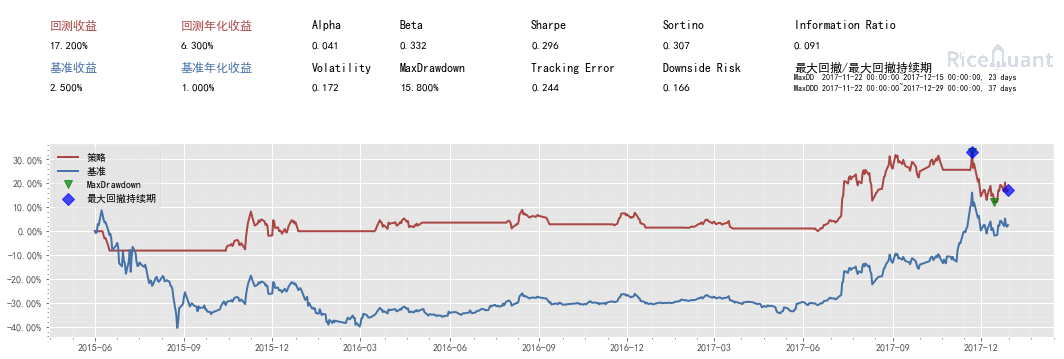

{'sys_analyser': {'summary': {'strategy_name': 'strategy',
   'start_date': '2015-06-01',
   'end_date': '2017-12-29',
   'strategy_file': 'strategy.py',
   'run_type': 'BACKTEST',
   'benchmark': '000001.XSHE',
   'STOCK': 1000000.0,
   'alpha': 0.041,
   'beta': 0.332,
   'sharpe': 0.296,
   'information_ratio': 0.091,
   'downside_risk': 0.166,
   'tracking_error': 0.244,
   'sortino': 0.307,
   'volatility': 0.172,
   'max_drawdown': 0.158,
   'total_value': 1172031.967,
   'cash': 301.967,
   'total_returns': 0.172,
   'annualized_returns': 0.063,
   'unit_net_value': 1.172,
   'units': 1000000.0,
   'benchmark_total_returns': 0.025,
   'benchmark_annualized_returns': 0.01},
  'trades':                      commission         exec_id  last_price  last_quantity  \
  datetime                                                                     
  2015-06-09 15:00:00    798.7392  15336997800066       16.98          58800   
  2015-06-16 15:00:00    735.7056  15336997800067       15.64

In [10]:
#MA_Strategy_3

import rqalpha
from rqalpha.api import *
import talib

def init(context):
    context.s1 = "000001.XSHE"
    context.SHORTPERIOD = 10
    context.LONGPERIOD = 30


def handle_bar(context, bar_dict):

    price = history_bars(context.s1, context.LONGPERIOD+1, '1d', 'close')

    short_avg = talib.SMA(price, context.SHORTPERIOD)
    long_avg = talib.SMA(price, context.LONGPERIOD)
    
    cur_position = context.portfolio.positions[context.s1].quantity
    shares = context.portfolio.cash/bar_dict[context.s1].close
    
    if len(long_avg)== context.LONGPERIOD+1:
        
        if  short_avg[-1] < short_avg[-2] and long_avg[-1] < long_avg[-2] and cur_position > 0:
            order_target_value(context.s1, 0)

        if short_avg[-1] > short_avg[-2] and long_avg[-1] > long_avg[-2]:
            order_shares(context.s1, shares)

config = {
  "base": {
    "start_date": "2015-06-01",
    "end_date": "2017-12-30",
    "accounts": {'stock':1000000},
    "benchmark": "000001.XSHE"
  },
  "extra": {
    "log_level": "error",
  },
  "mod": {
    "sys_analyser": {
      "enabled": True,
      "plot": True
    }
  }
}

rqalpha.run_func(init=init, handle_bar=handle_bar, config=config)

## 作业：
更换标的与均线类型回测策略。